[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Speech-Interaction-Technology-Aalto-U/itsp/HEAD?labpath=Modelling%2FVocoder.ipynb)

(content:vocoder)=
# Vocoder

The term [vocoder](https://en.wikipedia.org/wiki/Vocoder) comes from the words voice and encoder, and it refers to a process of applying a speech-like characteristic to a sound. In different fields, the word is used in different and sometimes contradictory fashion. Here we will discuss how we can impose a particular formant structure to any sound. The basic technology was invented by Homer Dudley in 1939 {cite}`dudley1939remaking`.

The basic idea of the vocoder is that any sound which has a formant structure, will be perceived as a speech sound. Thus if we modify a sound such that it has peaks in the spectrum similar to a speech sound, then it will be perceived as a speech sound. Many of the orginal features of the sound will be preserved, but it will then have the added *interpretation* as a speech sound. It is as if the original sound would become the carrier tone of the speech signal.

Recall that [formants](content:acoustic-properties) are peaks in the spectral envelope of the signal. That is, if we look at the gross (or macro) shape of the magnitude spectrum of a speech signal, it will feature a small number of peaks in particular in the region between 300 and 3500 Hz. The location (and amplitude) of these peaks correspond to specific vowels, or conversely, each vowel has a unique, identifying constellation of formant peaks.

To apply such formant structure to a signal, we need to first choose a valid vowel structure and then secondly, impose that structure onto a signal. Here we will analyze the formant structure of a speech signal and then multiply that onto the other signal.

## Formant analysis

### Mel-spectral envelope
The envelope structure, and thus also formant structure, can be conveniently modelled for a power spectrum, with a filterbank similar to [mel-spectrum analysis](content:melcepstrum). That is, 
1. Take the absolute square of the spectrum.
2. Calculate the mel-spectrum using the mel-filterbank by
   1. Create half-overlapping spectral bands on the mel-scale (denser at low frequencies).
   3. Calculate the energy in each band, weighted with a triangular function, such that the energy in the middle of the band has more weight than the edges.
4. Invert the band values back to a spectral power envelope.

In [1]:
# Initialization
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import scipy.fft
import numpy as np
import librosa
import helper_functions

speechfile = 'sounds/speech.wav'
window_length_ms = 30
window_hop_ms = 5

def pow2dB(x): return 10.*np.log10(np.abs(x)+1e-12)
def dB2pow(x): return 10.**(x/10.)

fs, data = wavfile.read(speechfile)

window_length = window_length_ms*fs//1000
spectrum_length = (window_length+1)//2
window_hop = window_hop_ms*fs//1000
total_length = len(data)
windowing_function = np.sin(np.pi*np.arange(0.5, window_length, 1.)/window_length)

melfilterbank, melreconstruct = helper_functions.melfilterbank(spectrum_length, fs/2, melbands=40)

# choose segment from random position in sample
starting_position = np.random.randint(total_length - window_length)

data_vector = data[starting_position:(starting_position+window_length),]
window = data_vector*windowing_function

In [2]:
spectrum = scipy.fft.rfft(window)

melspectrum = np.matmul(melfilterbank.T,np.abs(spectrum)**2)
envelopespectrum = np.matmul(melreconstruct.T,melspectrum)

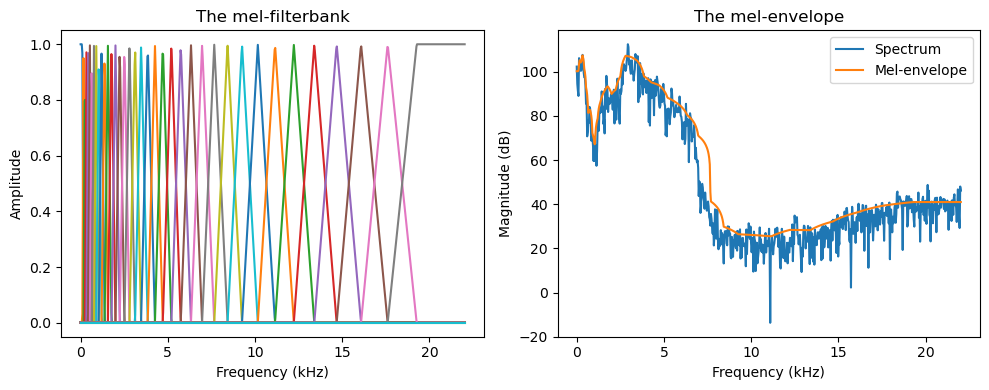

In [3]:
freqvec = np.arange(0,spectrum_length,1)*.5*fs/spectrum_length

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(freqvec/1000,melfilterbank)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude')
plt.title('The mel-filterbank')
                           
time_vector = np.linspace(0,window_length_ms,window_length)
frequency_vector = np.linspace(0,fs/2000,spectrum_length)

logspectrum = pow2dB(spectrum**2)
logenvelopespectrum = pow2dB(envelopespectrum)

plt.subplot(122)
plt.plot(freqvec/1000,logspectrum,label='Spectrum')
plt.plot(freqvec/1000,logenvelopespectrum,label='Mel-envelope')
plt.legend()
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude (dB)')
plt.title('The mel-envelope')

plt.tight_layout()
plt.show()

We can then analyze the envelopes of both the speech and the [other](https://freesound.org/s/624874/) sounds.

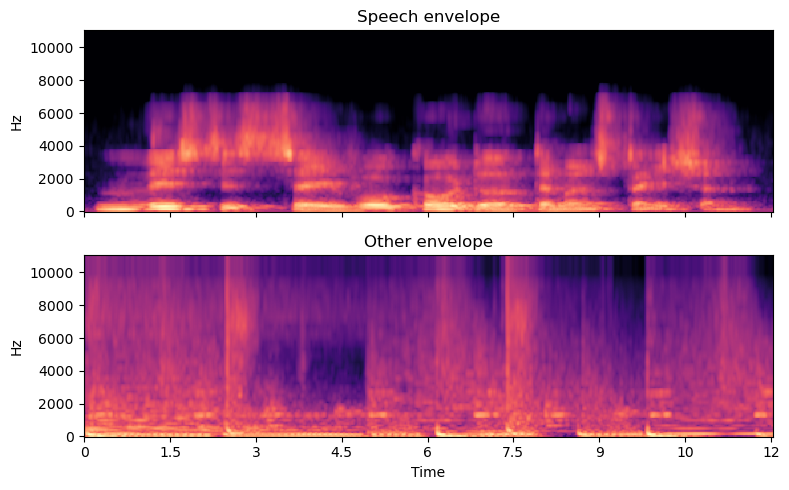

In [4]:
# Initialization
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import scipy.fft
import numpy as np
import librosa
import librosa.display
import helper_functions
import IPython.display as ipd

speechfile = 'sounds/speech.wav'
otherfile = 'sounds/other.wav'
window_length_ms = 30
window_hop_ms = 5

def pow2dB(x): return 10.*np.log10(np.abs(x)+1e-12)
def dB2pow(x): return 10.**(x/10.)

speech, fs = librosa.load(speechfile)
other, fs = librosa.load(otherfile)

window_length = window_length_ms*fs//1000
spectrum_length = (window_length+1)//2
window_hop = window_hop_ms*fs//1000
windowing_function = np.sin(np.pi*np.arange(0.5, window_length, 1.)/window_length)

melfilterbank, melreconstruct = helper_functions.melfilterbank(spectrum_length, fs/2, melbands=40)

Speech = librosa.stft(speech, n_fft=window_length, hop_length=window_hop)
Other = librosa.stft(other, n_fft=window_length, hop_length=window_hop)

# truncate to same length
frame_cnt = np.min([Speech.shape[1],Other.shape[1]])
Speech, Other = Speech[:,0:frame_cnt], Other[:,0:frame_cnt]

# envelope
SpeechEnvelope =  np.matmul(melreconstruct.T,np.matmul(melfilterbank.T,np.abs(Speech)**2))**.5
OtherEnvelope =  np.matmul(melreconstruct.T,np.matmul(melfilterbank.T,np.abs(Other)**2))**.5

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,5))
D = librosa.amplitude_to_db(np.abs(SpeechEnvelope), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',sr=fs, ax=ax[0])
ax[0].set(title='Speech envelope')
ax[0].label_outer()
D = librosa.amplitude_to_db(np.abs(OtherEnvelope), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',sr=fs, ax=ax[1])
ax[1].set(title='Other envelope')
ax[1].label_outer()
plt.tight_layout()
plt.show()

ipd.display(ipd.HTML("Speech"))
ipd.display(ipd.Audio(speech,rate=fs))
ipd.display(ipd.HTML("Other"))
ipd.display(ipd.Audio(other,rate=fs))

## Applying the envelope

We can then extract the mel-envelopes of the speech and other signals, remove the envelope shape from the other by division, and apply the speech envelope by multiplication as

$$
\text{Spectrum[Vocoder]} = \text{Spectrum[Other]}\times\frac{\text{Envelope[Speech]}}{\text{Envelope[Other]}}
$$

where $\text{Spectrum[X]}$ and $\text{Envelope[X]}$ refer to the spectrum and magnitude envelope of $\text{X}$, respectively.

In [5]:
# Initialization
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import scipy.fft
import numpy as np
import librosa
import librosa.display
import helper_functions
import IPython.display as ipd

# config
speechfile = 'sounds/speech.wav'
otherfile = 'sounds/other.wav'
window_length_ms = 30
window_hop_ms = 5

# load
speech, fs = librosa.load(speechfile)
other, fs = librosa.load(otherfile)

# constants
window_length = window_length_ms*fs//1000
spectrum_length = (window_length+1)//2
window_hop = window_hop_ms*fs//1000
windowing_function = np.sin(np.pi*np.arange(0.5, window_length, 1.)/window_length)

melfilterbank, melreconstruct = helper_functions.melfilterbank(spectrum_length, fs/2, melbands=40)

# stft
Speech = librosa.stft(speech, n_fft=window_length, hop_length=window_hop)
Other = librosa.stft(other, n_fft=window_length, hop_length=window_hop)

# truncate to same length
frame_cnt = np.min([Speech.shape[1],Other.shape[1]])
Speech, Other = Speech[:,0:frame_cnt], Other[:,0:frame_cnt]

# envelopes
SpeechMelEnvelope =  np.matmul(melfilterbank.T,np.abs(Speech)**2)
OtherMelEnvelope =  np.matmul(melfilterbank.T,np.abs(Other)**2)

SpeechEnvelope =  np.matmul(melreconstruct.T,SpeechMelEnvelope)**.5
OtherEnvelope =  np.matmul(melreconstruct.T,OtherMelEnvelope)**.5

In [6]:
# Vocoder
Vocoder = Other * SpeechEnvelope / OtherEnvelope
vocoder = librosa.istft(Vocoder, hop_length=window_hop)

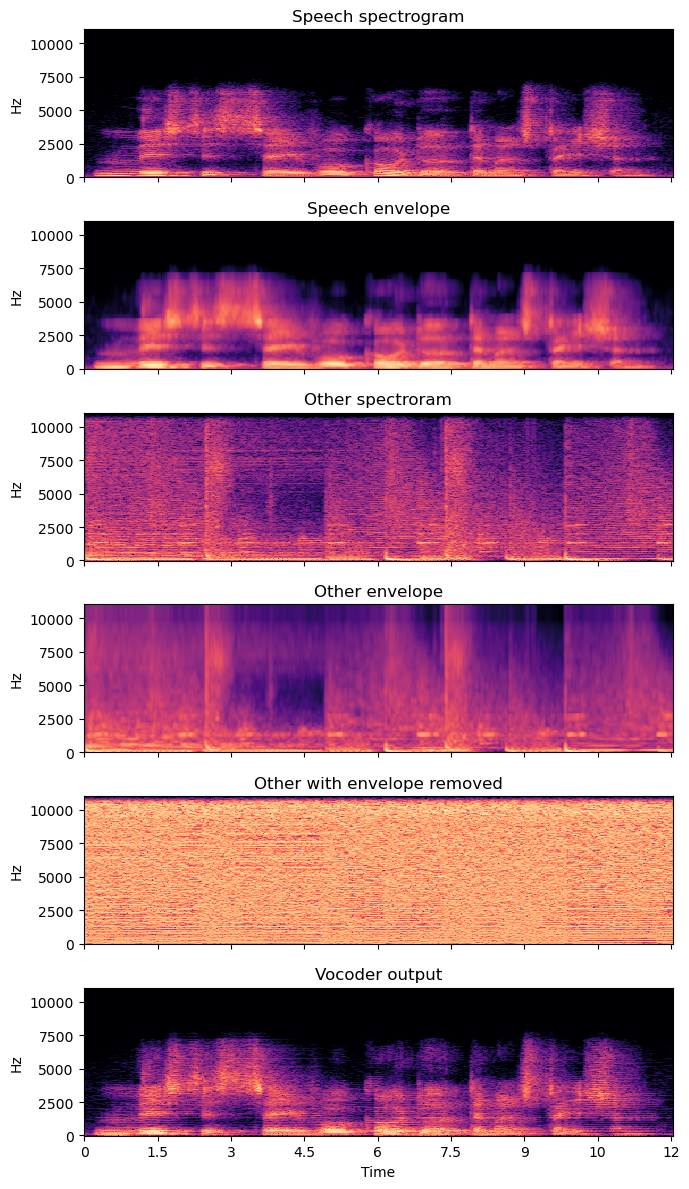

In [7]:
# Visualize
fig, ax = plt.subplots(nrows=6, ncols=1, sharex=True, figsize=(7,12))
D = librosa.amplitude_to_db(np.abs(Speech), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',sr=fs, ax=ax[0])
ax[0].set(title='Speech spectrogram')
ax[0].label_outer()
D = librosa.amplitude_to_db(np.abs(SpeechEnvelope), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',sr=fs, ax=ax[1])
ax[1].set(title='Speech envelope')
ax[1].label_outer()
D = librosa.amplitude_to_db(np.abs(Other), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',sr=fs, ax=ax[2])
ax[2].set(title='Other spectroram')
ax[2].label_outer()
D = librosa.amplitude_to_db(np.abs(OtherEnvelope), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',sr=fs, ax=ax[3])
ax[3].set(title='Other envelope')
ax[3].label_outer()
D = librosa.amplitude_to_db(np.abs(Other/OtherEnvelope), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',sr=fs, ax=ax[4])
ax[4].set(title='Other with envelope removed')
ax[4].label_outer()
D = librosa.amplitude_to_db(np.abs(Vocoder), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',sr=fs, ax=ax[5])
ax[5].set(title='Vocoder output')
ax[5].label_outer()
plt.tight_layout()
plt.show()

ipd.display(ipd.HTML("Speech"))
ipd.display(ipd.Audio(speech,rate=fs))
ipd.display(ipd.HTML("Other"))
ipd.display(ipd.Audio(other,rate=fs))
ipd.display(ipd.HTML("Vocoder"))
ipd.display(ipd.Audio(vocoder,rate=fs))

In the vocoder output sound, we can clearly discern both features of the speech and other signals. Namely, the fine spectral structure, such as the pitch of instruments remains from the other signal, while the phoneme-identity and thus the text content of the speech signal is also recovered.

## Applications

The most obvious use of vocoders is popular music, where hits such as ["The Robots" by Kraftwerk](https://youtu.be/vpTRDY5XkrY?t=70) prominently feature the vocoder. Such entertainment however belies the true value of vocoders. Conversely, they highlight the power of vocoders by showing how important the envelope structure is to our perception.

In any case, vocoders are widely used as a component of many applications. For example, speech coding by [Code-excited linear prediction (CELP)](content:CELP) uses [linear prediction](content:linearprediction) to model the envelope. In general, speech and audio codecs are all based on some sort of envelope modelling and thus they are in fact using a vocoder structure. 
Similarly, many speech synthesis models use model the envelope and the excitation separately, thus also employing vocoders. Speech enhancement by [noise attenuation](content:noiseattenuation) often use spectral masks, which can be interepreted as envelope models. The [mel-frequency cepstral coefficient (MFCC)](content:mfcc) representation is a  classical feature used in speech recognition and voice activity detectors to model the envelope though only for analysis. It is thus clear that in a loose interpretation, almost all areas of speech processing use at least similar ideas, if not a complete implementation of a vocoder.

## References

```{bibliography}
:filter: docname in docnames
```